In [14]:
from typing import Any, Callable, Dict, Optional, Union

from deep_visual_descriptor.model import geodesic_feature_network
from sklearn.decomposition import PCA

import tensorflow as tf
from PIL import Image
import numpy as np
import functools

model_hparams = {
      'loss_hparams': {
          'correspondence_loss_weight': 0.3,
          'triplet_loss_weight': 2.0,
          'dense_geodesic_loss_weight': 6.0,
          'cross_dense_geodesic_loss_weight': 4.0,
          'sparse_ordinal_geodesic_loss_weight': 2.0,
      },
      'flow_scale_factor': 20.0,
      'return_feature_pyramid': False,
      'feature_extractor': 'resunet',
      'eval_search_size': (384, 256),
      'filters_sequence': (16, 32, 64, 96, 128, 128, 196),
  }

def get_training_elements(
    model_component: str,
    model_hparams: Dict[str, Any]) -> Callable[..., tf.keras.Model]:
  """Get model architecture."""

  if model_component == 'GeoFeatureNet':
    create_model_fn = functools.partial(geodesic_feature_network.GeoFeatureNet,
                                        model_hparams)
  else:
    raise ValueError('Unknown model_component: %s' % model_component)

  return create_model_fn

In [30]:
def parse_matting_data(folder_path, name):
  image_name = name + '.jpg'
  matting_name = name + '_mask' + '.png'

  image_path = folder_path + image_name
  matting_path = folder_path + matting_name

  fn = image_path
  img_raw = tf.io.read_file(fn)
  image = tf.cast(tf.image.decode_image(img_raw), tf.float32)
  image = tf.expand_dims(image, axis=0)
  image = tf.image.resize(image, [384, 256])

  fn = matting_path
  matting_raw = tf.io.read_file(fn)
  matting = tf.cast(tf.image.decode_image(matting_raw), tf.float32)
  matting = tf.expand_dims(matting, axis=0)
  matting = tf.image.resize(matting, [384, 256], 'nearest')
  image_bg = image
  mask = matting > 240
  intensity = tf.reduce_sum(image, axis=-1, keepdims=True)
  color_mask = intensity > 0
  mask = tf.math.logical_and(mask, color_mask)

  image = tf.where(tf.tile(mask, [1,1,1,3]), image, tf.zeros_like(image))
  image = image / 127.5 - 1 

  return image, image_bg, mask


def eval_step(batch):
  training_loss, scalar_summaries, image_summaries = model.get_eval_outputs(batch)
  feature_map_pair = model(batch['images'], training=True)
  return training_loss, scalar_summaries, image_summaries, feature_map_pair

In [31]:
checkpoint_path = './checkpoint/pretrained_model'

create_model_fn = get_training_elements(
      model_component='GeoFeatureNet', model_hparams=model_hparams)

model = create_model_fn()

checkpoint = tf.train.Checkpoint(
      model=model,
      step=tf.Variable(-1, dtype=tf.int64),
      training_finished=tf.Variable(False, dtype=tf.bool),
  )

status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()
status.expect_partial()


(384, 256)


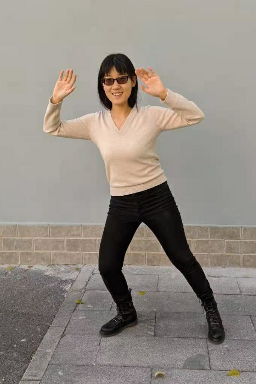

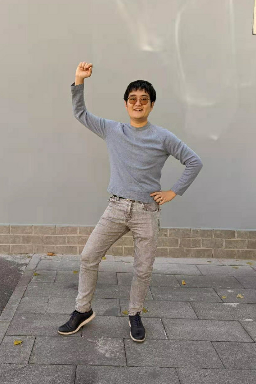

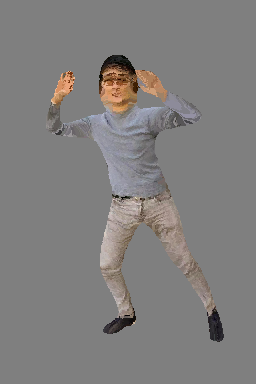

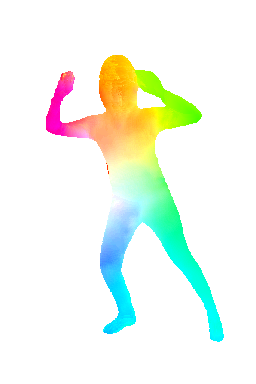

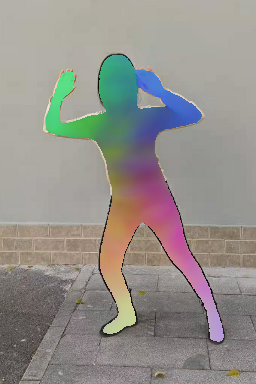

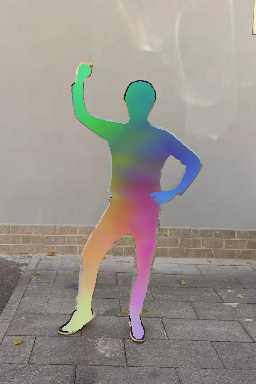

In [29]:
folder_path = './test/'
name2 ='im1'
name1 ='im3'

image1, image_bg1, mask1=parse_matting_data(folder_path, name1)
image2, image_bg2, mask2=parse_matting_data(folder_path, name2)

images = tf.concat([image1, image2], axis=0)
image_bgs = tf.concat([image_bg1, image_bg2], axis=0)
masks = tf.concat([mask1, mask2], axis=0)

batch = {}
batch['images'] = tf.expand_dims(images, axis=0)
batch['masks'] = tf.expand_dims(masks, axis=0)
batch['flows'] = batch['images'][:,0,:,:,:2]
batch['flow_mask'] = batch['masks'][:,0]
batch['is_inter'] = tf.zeros([2], tf.bool)

training_loss, scalar_summaries, image_summaries, features = eval_step(batch)
# PCA
feature_list = []
mask1 = batch['masks'].numpy()[0,0,:,:,0]
mask2 = batch['masks'].numpy()[0,1,:,:,0]
feature1 = features[0][0].numpy()
feature2 = features[1][0].numpy()
print(mask1.shape)
feature_sample1 = feature1[mask1]
feature_sample2 = feature2[mask2]
feature_list.append(feature_sample1)
feature_list.append(feature_sample2)
pca = PCA(n_components=3)
feature_sample = np.concatenate(feature_list, axis=0)
pca.fit(feature_sample)

feature1_sample_new = pca.transform(feature_sample1)
feature2_sample_new = pca.transform(feature_sample2)

feature1_sample_new = (feature1_sample_new + 1)/2
feature2_sample_new = (feature2_sample_new + 1)/2


warped_image_search = image_summaries['warped_image_search']
vis_flow_search = image_summaries['flow_search']

vis_image1 = image_bgs[0].numpy().astype(np.uint8)
vis_image2 = image_bgs[1].numpy().astype(np.uint8)
vis_warped_image_search = ((warped_image_search[0].numpy()*255)).astype(np.uint8)
vis_flow_search = ((vis_flow_search[0].numpy()) * 255).astype(np.uint8)

vis_image_bgs = image_bgs.numpy().astype(np.uint8)
vis_image_bgs[0][mask1] = (feature1_sample_new * 255).astype(np.uint8)
vis_image_bgs[1][mask2] = (feature2_sample_new * 255).astype(np.uint8)

display(Image.fromarray(vis_image1))
display(Image.fromarray(vis_image2))
display(Image.fromarray(vis_warped_image_search))
display(Image.fromarray(vis_flow_search))
display(Image.fromarray(vis_image_bgs[0]))
display(Image.fromarray(vis_image_bgs[1]))